In [ ]:
import os
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType
)
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [ ]:
!pip install -q transformers datasets accelerate peft bitsandbytes sentencepiece huggingface_hub wandb scikit-learn lion-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:128"
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
def optimize_memory():
    """
    Optimize GPU memory and provide memory utilization tracking
    """
    # Clear CUDA cache
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    # Set lower precision for reduced memory footprint
    torch.set_float32_matmul_precision('medium')

    # Memory tracking function with safe import
    def print_gpu_utilization():
        try:
            import pynvml

            # Initialize NVML
            pynvml.nvmlInit()

            try:
                # Get the first GPU device
                handle = pynvml.nvmlDeviceGetHandleByIndex(0)

                # Retrieve memory information
                info = pynvml.nvmlDeviceGetMemoryInfo(handle)

                # Print memory usage
                print(f"GPU Total Memory: {info.total / 1024**2:.2f} MB")
                print(f"GPU Used Memory: {info.used / 1024**2:.2f} MB")
                print(f"GPU Free Memory: {info.free / 1024**2:.2f} MB")

            except Exception as device_error:
                print(f"Error getting GPU memory info: {device_error}")

            finally:
                # Always shutdown NVML
                pynvml.nvmlShutdown()

        except ImportError:
            # Fallback to PyTorch memory reporting if NVML is not available
            print("NVML not available. Using PyTorch memory tracking.")
            print(f"Allocated GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
            print(f"Cached GPU Memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    # Print GPU utilization
    print_gpu_utilization()

    # Additional memory optimization settings
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:128"

In [ ]:
def load_model_with_minimal_memory(model_id):
    # Aggressive quantization configuration
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )

    # Load model with minimal memory footprint
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",  # Intelligent device mapping
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        attn_implementation="flash_attention_2",  # Most memory-efficient attention
        use_cache=False
    )

    return model

In [ ]:
def create_efficient_tokenizer(model_id):
    tokenizer = AutoTokenizer.from_pretrained(
        model_id,
        use_fast=True,
        add_eos_token=True,
        add_bos_token=True
    )

    # Set padding and truncation strategies
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return tokenizer

In [ ]:
def create_efficient_dataset(dataset, tokenizer, max_length=512):
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )

    # Use streaming for large datasets
    dataset = dataset.shuffle(seed=42)
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names,
        num_proc=4,  # Parallel processing
        batch_size=1000
    )

    return tokenized_dataset

In [ ]:

# Memory-Aware Training Arguments
def create_memory_optimized_training_args():
    return TrainingArguments(
        output_dir="./llama2_finetune",

        # Extreme Memory Optimization
        per_device_train_batch_size=4,  # Minimal batch size
        gradient_accumulation_steps=250,  # Simulate larger batch
        gradient_checkpointing=True,

        # Learning Rate and Optimization
        learning_rate=1e-4,
        weight_decay=0.01,

        # Training Constraints
        max_grad_norm=0.3,
        max_steps=50,

        # Memory and Precision Management
        fp16=True,
        bf16=False,
        optim="adamw_torch_fused",  # Most memory-efficient optimizer

        # Logging and Evaluation
        logging_dir="./logs",
        logging_strategy="steps",
        logging_steps=10,
        evaluation_strategy="steps",
        eval_steps=50,

        # Save Management
        save_total_limit=3,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",

        # Resource Management
        dataloader_num_workers=4,
        dataloader_prefetch_factor=2,
    )

In [ ]:
# Uninstall existing packages
!pip uninstall flash-attn transformers torch

# Install compatible versions
!pip install torch torchvision torchaudio

Found existing installation: flash_attn 2.7.4.post1
Uninstalling flash_attn-2.7.4.post1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/flash_attn-2.7.4.post1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/flash_attn/*
    /usr/local/lib/python3.11/dist-packages/flash_attn_2_cuda.cpython-311-x86_64-linux-gnu.so
    /usr/local/lib/python3.11/dist-packages/hopper/*
Proceed (Y/n)? Y
  Successfully uninstalled flash_attn-2.7.4.post1
Found existing installation: transformers 4.48.3
Uninstalling transformers-4.48.3:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.11/dist-packages/transformers-4.48.3.dist-info/*
    /usr/local/lib/python3.11/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.48.3
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 45.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C
^C


In [ ]:
!pip install transformers
!pip install flash-attn --no-build-isolation

  Using cached flash_attn-2.7.4.post1-cp311-cp311-linux_x86_64.whl


In [ ]:
#Main Training Function
def train_with_memory_optimization():
    # Initial memory optimization
    optimize_memory()

    # Model and Tokenizer Setup
    MODEL_ID = "meta-llama/Llama-2-7b-hf"
    model = load_model_with_minimal_memory(MODEL_ID)
    tokenizer = create_efficient_tokenizer(MODEL_ID)

    # LoRA Configuration for Efficient Fine-Tuning
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=16,  # LoRA rank
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=[
            "q_proj", "k_proj", "v_proj",
            "o_proj", "gate_proj",
            "down_proj", "up_proj"
        ]
    )

    # Prepare model for efficient training
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, peft_config)

    # Load and Preprocess Dataset
    dataset = load_dataset("imdb", split="train+test")
    tokenized_dataset = create_efficient_dataset(
        dataset,
        tokenizer
    )

    # Split dataset
    train_dataset = tokenized_dataset.select(range(int(len(tokenized_dataset)*0.8)))
    eval_dataset = tokenized_dataset.select(range(int(len(tokenized_dataset)*0.8), len(tokenized_dataset)))

    # Training Arguments
    training_args = create_memory_optimized_training_args()

    # Data Collator
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

    # Custom Metrics Function
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)

        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='binary'
        )

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Start Training with Memory Monitoring
    try:
        trainer.train()
    except RuntimeError as e:
        print(f"Training interrupted: {e}")
        # Attempt to save partial model
        trainer.save_model("./partial_model")
        return trainer

    # Final Model Save
    trainer.save_model("./final_llama2_model")
    return trainer

# Execute Training

In [ ]:
trainer = train_with_memory_optimization()

GPU Total Memory: 40960.00 MB
GPU Used Memory: 27349.12 MB
GPU Free Memory: 13610.88 MB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss


Training interrupted: CUDA out of memory. Tried to allocate 12.70 GiB. GPU 0 has a total capacity of 39.56 GiB of which 11.96 GiB is free. Process 59740 has 27.59 GiB memory in use. Of the allocated memory 26.49 GiB is allocated by PyTorch, and 610.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [ ]:
# Print training loss history
print("Training Loss History:", trainer.state.log_history)

Training Loss History: [{'loss': 2.4852, 'grad_norm': 0.32483744621276855, 'learning_rate': 9.5e-05, 'epoch': 0.004, 'step': 10}, {'loss': 2.3801, 'grad_norm': 0.33348119258880615, 'learning_rate': 9e-05, 'epoch': 0.008, 'step': 20}, {'loss': 2.3702, 'grad_norm': 0.3944324553012848, 'learning_rate': 8.5e-05, 'epoch': 0.012, 'step': 30}, {'loss': 2.3568, 'grad_norm': 0.26214301586151123, 'learning_rate': 8e-05, 'epoch': 0.016, 'step': 40}, {'loss': 2.339, 'grad_norm': 0.26442858576774597, 'learning_rate': 7.500000000000001e-05, 'epoch': 0.02, 'step': 50}]


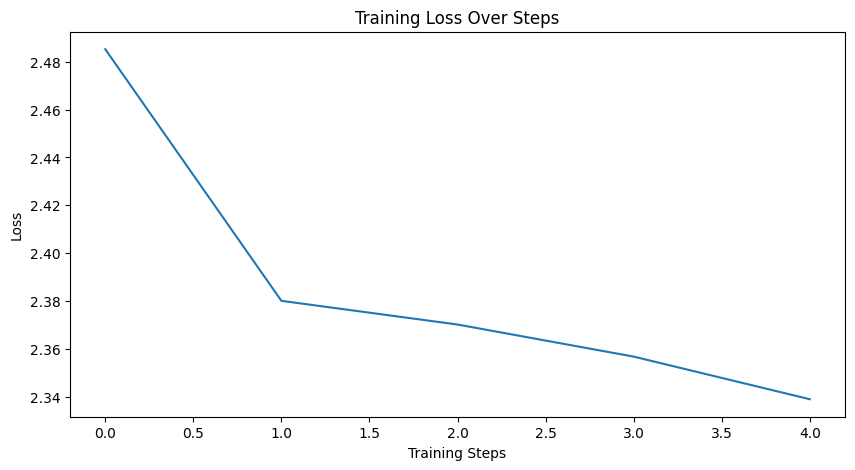

In [ ]:
import matplotlib.pyplot as plt

# Extract training losses
training_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]

plt.figure(figsize=(10, 5))
plt.plot(training_losses)
plt.title('Training Loss Over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.show()